In school, I had the opportunity of doing a project where the goal was, given EEG signals, what features were more important than others in terms of the likelihood of a seizure, and also determine a prediction on whether a seizure was likely to occur or not. This has been worked on previously in several research papers, and is a pretty straight forward application of data mining. Typically, some type of entropy measurement is used as a predictor in place of the raw time series data, and then a predictive algorithm is used for final classification. The entropy measures reduce the dimensionality of the problem, since a sliding window is used to estimate the entropy about each neighborhood of time series data. Entropy measures are also useful for this task because they can be used for describing how much energy is within each frequency band. I used a wavelet entropy measurement in my project to estimate this. Since, to form a wave type like a seizure, frequency band energies will always narrow so that energy is concentrated within a specific frequency, decreases in entropy are also a great indicator of the likelihood of a seizure occurring. The success of entropy based measures also strongly suggests that the total energy or size of the oscillations is not of critical importance for this particular prediction problem, as the entropy measures themselves consist of only the ratio of energy within each frequency band, and the total energy is not kept as a predictor. 

Anyways, one thing I wanted to try was replacing the wavelet entropy measure with a different decomposition method, Empirical Mode Decomposition(EMD), and also use some more advanced models. EMD is more adaptive than wavelets, as the basis function, rather than being predefined like a wavelet basis, is determined from the data itself, making it a more appropriate tool for highly non-stationary time series like EEG signals. In my original project, I used a random forest and a support vector machine as models. Both scored very highly, as the combination of entropy measures and machine learning models made it a relatively easy task.

To make this a bit more challenging, I use a similar dataset to the one I used, but there are now five classes, each indicating a different state of activity. The dataset was downloaded from https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition

The above dataset contains 11,500 separate time series, each which records a 1 second window of EEG activity at different points in time, using 500 different subjects. Each recording encompasses 178 data points over that second span of time. This version of the dataset breaks classification into five possible categories. This is nice, as it will better test the preprocessing and modeling capacities chosen.

- eyes open
- eyes closed
- healty brain activity (non-seizure)
- unhealthy brain activity (EEG recording of tumor area, during non-seizure period)
- Recording of Seizure


In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('C:/Users/jws0258/Downloads/data.csv')
dfx = df.iloc[3:7,1:179]
dfx2 = df.iloc[1:2000,1:179]
dfx_m = dfx.values

## Visualization

Before moving into preprocessing and model selection, it is worth doing some basic visualization of the data. First, a random sampling of some time series will be shown below.

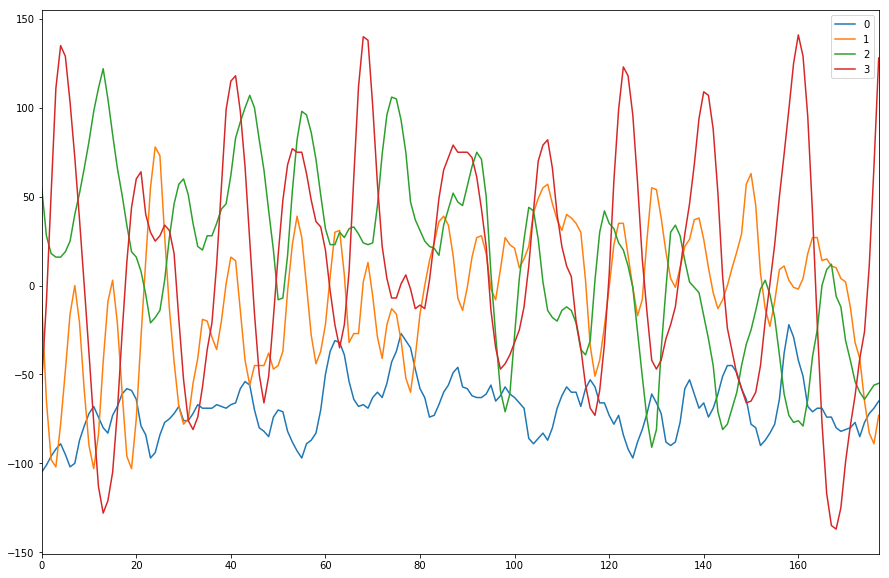

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

dfx_m1 = np.transpose(dfx_m)
ts1 = pd.DataFrame(dfx_m1)
ts1.plot(figsize = (15,10))

As can be seen above, there is some highly nonstationary features in the above time series graph. Note the time series in red as well. It is highly synchronized. Again, from an entropy perspective, this is because the oscillatory energy is primarily in only one frequency band and hence, a frequency band based entropy measures will be very low for that particular time series.

## Data Preprocessing

Data preprocessing will consist of two steps. First, Empirical mode decomposition will be performed. It decomposes each time series from a non-stationary time series into a set of stationary, well behaved (in the sense that each local maximum and minimum of the resulting time series set, the trajectory crosses zero in between.) time series. The resulting time series components are referred to as intrinsic mode functions. Also, intrinsic mode functions have instantaneous frequencies, so there is no need to window the data. Each point in time can generate a separate entropy measurement.

Most machine learning methods assume the data is stationary. That is, the generating function that produces the results stays constant over time. While this is rarely strictly true, usually it is close enough that prediction results do not suffer substantially. In fact, one benefit of using entropy measures in the place of raw time series data from prediction, is that it replaces the original, non-stationary time series, with a particular description of the time series state at multiple points. This abstraction of the data makes it easier for machine learning modeling techniques to find patterns that do not constantly shift.



Before applying EMD to all the data, first, an example of a decomposed time series is shown below.

INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.


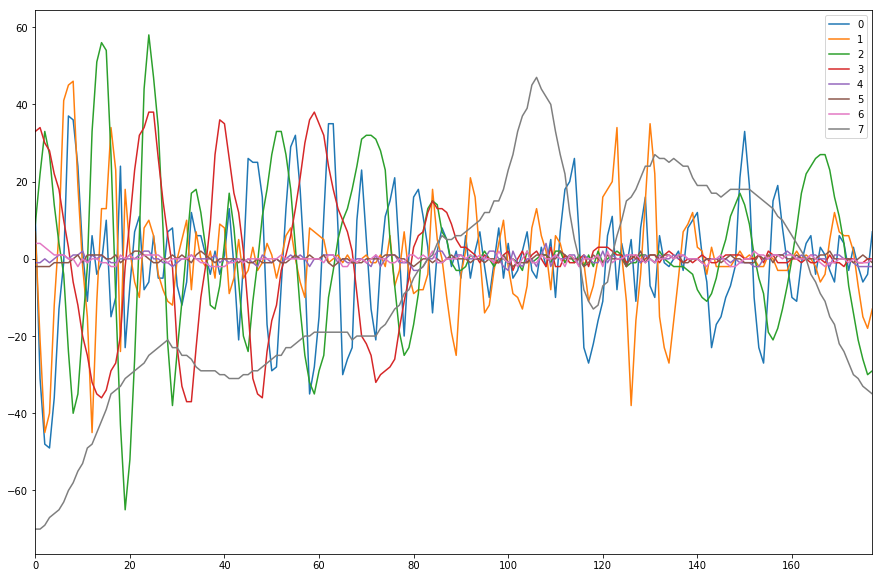

In [7]:
%matplotlib inline
from PyEMD import EMD

emd = EMD()
IMFs = emd(dfx.iloc[1,:], max_imf = 7)

IMFs2 = np.transpose(IMFs)
df_imfs = pd.DataFrame(IMFs2)
df_imfs.plot(figsize = (15,10))

The above time series shows a single EEG, decomposed into intrinsic mode functions. Notice how much simpler the IMFs are in comparison to the original time series.

In [ ]:
from PyEMD import EMD
EMD_list = []
for i in range(len(1)):
    emd = EMD()
    IMFs = emd(dfx2.iloc[i,:], max_imf=5)
    EMD_list.append(IMFs)
    

One downside of using empirical mode decomposition, is that the number of resulting intrinsic mode functions can vary between samples. This is part of the tradeoff in having a flexible, data dependent basis. Also, it is a heavily iterative algorithm, and is slow. There is also some issue with mode mixing, that is frequencies that should be partitioned into a different IMF are incorrectly added to another IMF.



    


While support vector machines and random forests are adequate for time series, without additional features, there are better options. The random forest will get difference information, by applying a kernel to each time series, and a random forest implementation which samples from the kernel in order to build decision trees. This allows for better capturing the distance between values in the time series. This indirectly captures entropy related information as well, since IMF values at the same point in time are also compared to one another. The other model used will be a wavenet architecture. 

